# Homework #07

In [1]:
import secrets
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.stats import mode
from sklearn.metrics import pairwise_distances
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
data_path = Path().resolve().parent / "data"

In [3]:
# Random seed for reproducibility
# secrets.randbits(128) # 208905213533139122735706682150229709525
rng = np.random.default_rng(208905213533139122735706682150229709525)
indices_train = rng.choice(5000, 2500, replace=False)
indices_test = rng.choice(800, 400, replace=False)
flag_full_dataset = False  # If it is True it will use full train and test datasets

In [4]:
train_list = []  # Auxiliary list of train datasets
for f in data_path.glob("train*.txt"):
    # Sample or full dataset
    raw_data = np.loadtxt(f) if flag_full_dataset else np.loadtxt(f)[indices_train, :]
    target = raw_data[:, [0]]  # Target values, i.e. digit
    features = raw_data[:, 1:] / raw_data[:, 1:].max(axis=1, keepdims=True)
    train_list.append(np.hstack((target, features)))  # Add to the temp list
train_data = np.vstack(train_list)  # Concatenate train datasets
train_data.shape

(25000, 785)

In [5]:
# Similar to train dataset
test_list = []
for f in data_path.glob("test*.txt"):
    raw_data = np.loadtxt(f) if flag_full_dataset else np.loadtxt(f)[indices_test, :]
    target = raw_data[:, [0]]
    features = raw_data[:, 1:] / raw_data[:, 1:].max(axis=1, keepdims=True)
    test_list.append(np.hstack((target, features)))
test_data = np.vstack(test_list)
test_data.shape

(4000, 785)

In [6]:
# Split datasets into features matrices and target vectors
X_train = train_data[:, 1:]
y_train = train_data[:, 0].astype(int)
X_test = test_data[:, 1:]
y_test = test_data[:, 0].astype(int)

In [7]:
def accuracy(y_pred, y_real):
    return np.mean(y_pred == y_real)

In [8]:
# Distances
eps = 1
dist_test_train = pairwise_distances(X_test, X_train, "euclidean", n_jobs=-1)
weights_array = 1 / (dist_test_train ** 2 + eps)

## Unweighted

In [9]:
pred_dict = {}
for k in range(1, 8):
    argsort_dist = np.argsort(dist_test_train, axis=1)[:, :k]  # Sort indexes
    nearest_labels = y_train[argsort_dist]  # Get nearest labels from train data
    y_pred = mode(nearest_labels, axis=1, keepdims=False)[0]  # Compute mode from labels
    pred_dict[k] = y_pred
    print(f"k = {k} - Accuracy {accuracy(y_pred, y_test)}")

## Weighted

In [10]:
y_unique = np.unique(y_test)  # Get unique targets labels (digits)
n_labels = len(y_train)
n_test, _ = X_test.shape

In [11]:
pred_weight_dict = {}
for k in range(4, 5):
    argsort_dist = np.argsort(dist_test_train, axis=1)[:, :k]  # Sort indexes
    nearest_labels = y_train[argsort_dist]  # Nearest labels
    nearest_weights = np.take_along_axis(weights_array, argsort_dist, axis=1)  # Weight of nearest
    objective_array = np.zeros(shape=(n_test, n_labels))  # Empty sum of objective function
    # Iterate for each label
    for label in y_unique:
        # Create a mask and then sum the weights
        mask = nearest_labels == label
        objective_mask = np.ma.masked_array(nearest_weights, ~mask).sum(axis=1)
        objective_array[:, label] = objective_mask.filled(0)
    y_pred = np.argmax(objective_array, axis=1)  # Argmax objective function
    pred_weight_dict[k] = y_pred
    print(f"k = {k} - Accuracy {accuracy(y_pred, y_test)}")

k = 4 - Accuracy 0.9605


In [12]:
argsort_dist = np.argsort(dist_test_train, axis=1) # All the neighbors
nearest_labels = y_train[argsort_dist]
nearest_weights = np.take_along_axis(weights_array, argsort_dist, axis=1)
objective_array = np.zeros(shape=(n_test, n_labels))
for label in y_unique:
    mask = nearest_labels == label
    objective_mask = np.ma.masked_array(nearest_weights, ~mask).sum(axis=1)
    objective_array[:, label] = objective_mask.filled(0)
y_pred = np.argmax(objective_array, axis=1)
print(f"Accuracy {accuracy(y_pred, y_test)}")


    Accuracy weighted KNN with 4 neighbors was 96.05% and with
    approximately 95% probability the true accuracy lies in the interval
    [0.9545, 0.9665]



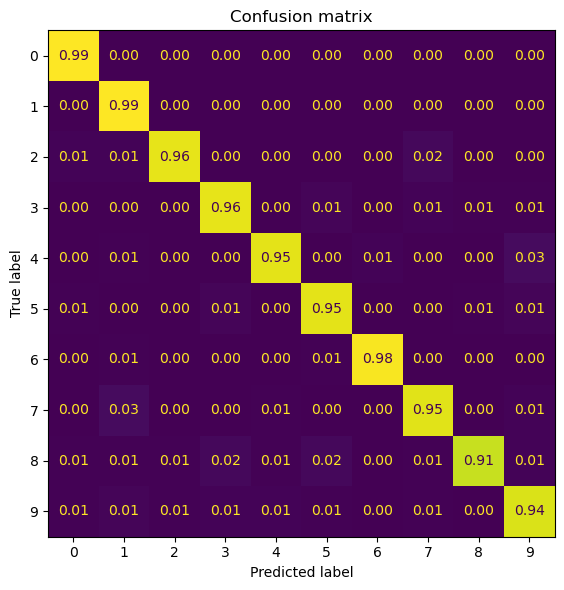

In [20]:
k = 4
y_pred = pred_weight_dict[k]  # Best performance
error_h = accuracy(y_pred, y_test)
sigma = np.sqrt(error_h * (1 - error_h) / y_test.size)
print(f"""
    Accuracy weighted KNN with {k} neighbors was {error_h:.2%} and with
    approximately 95% probability the true accuracy lies in the interval
    [{error_h - 1.96 * sigma:.4f}, {error_h + 1.96 * sigma:.4f}]
"""
)
# Confusion matrix - row normalization
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    normalize="true",
    values_format=".2f",
    ax=ax
)
ax.images[0].colorbar.remove()
ax.set_title(f"Confusion matrix")
fig.tight_layout()
fig.savefig(
    f"hw07_confusion_matrix.png",
    dpi=300
)